<font size ='3'>*First, let's read in the data and necessary libraries*<font/>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mypy import print_side_by_side
from mypy import display_side_by_side
#https://stackoverflow.com/a/44923103/8067752
%matplotlib inline

pd.options.mode.chained_assignment = None

In [6]:
b_cal = pd.read_csv('boston_calendar.csv')
s_cal = pd.read_csv('seatle_calendar.csv')
b_list = pd.read_csv('boston_listings.csv')
s_list = pd.read_csv('seatle_listings.csv')
b_rev = pd.read_csv('boston_reviews.csv')
s_rev = pd.read_csv('seatle_reviews.csv')

 _______________________________________________________________________________________________________________________

## Task 1: Business Understanding <font size="2"> *(With some Data Preperation)*</font>  
<font size="3"> *My work flow will be as follows, I will explore the data with some cleaning to get enough insights to formulate questions, then, within every question I will follow the rest of the steps of the CRISP-DM framework.*</font>  

### Step 1: Basic Exploration with some cleaning
<font size ='3'>*To be familiarized with the Data and to gather insights to formulate questions*<font/>

> **Boston & Seatle Calendar**

In [7]:
display_side_by_side(b_cal.head(), s_cal.head(), titles = ['b_cal', 's_cal'])

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN
,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN


<font size ='3'>*Check the sizes of cols and rows & check Nulls*<font/>

In [153]:
print_side_by_side('Boston Cal:', 'Seatle Cal:', b=0)
print_side_by_side('Shape:',b_cal.shape,"Shape:",  s_cal.shape)
print_side_by_side("Cols with nulls: ", b_cal.isnull().sum()[b_cal.isnull().sum()>0].index[0],"Cols with nulls: ", s_cal.isnull().sum()[s_cal.isnull().sum()>0].index[0])
print_side_by_side("Null prop of price column: ", round(b_cal.price.isnull().sum()/b_cal.shape[0], 2),"Null prop of price column: ", round(s_cal.price.isnull().sum()/s_cal.shape[0], 2))
print_side_by_side("Proportion of False(unit unavailable):", round(b_cal.available[b_cal.available =='f' ].count()/b_cal.shape[0],2),"Proportion of False(unit unavailable):", round(s_cal.available[s_cal.available =='f' ].count()/s_cal.shape[0],2))
print_side_by_side("Nulls when units are available: ", b_cal[b_cal['available']== 't']['price'].isnull().sum(),"Nulls when units are available: ", s_cal[s_cal['available']== 't']['price'].isnull().sum() )
print('\n')

Boston Cal:                                              Seatle Cal:
Shape:  (1308890 4)                                      Shape:  (1393570 4)
Cols with nulls:   price                                 Cols with nulls:   price
Null prop of price column:   0.51                        Null prop of price column:   0.33
Proportion of False(unit unavailable):  0.51             Proportion of False(unit unavailable):  0.33
Nulls when units are available:   0                      Nulls when units are available:   0




<font size ='3'>*Let's do some cleaning, first, let's transfer `date` column to datetime to ease manipulation and analysis. I will also create a dataframe with seperate date items from the Date column, to check the time interval along which the data was collected. In addition to that, let's transform `price` and `available` into numerical values*<font/>

In [154]:
def create_dateparts(df, date_col): 
    """
    INPUT
    df -pandas dataframe
    date_col -list of columns to break down into columns of years,months and days.
    
    OUTPUT
    df - a dataframe with columns of choice transformed in to columns of date parts(years,months and days)
    """
    df['date'] = pd.to_datetime(df.date)
    b_date_df = pd.DataFrame()
    b_date_df['year'] = df['date'].dt.year
    b_date_df['month'] = df['date'].dt.month
    b_date_df['day'] =df['date'].dt.strftime("%A")
    #b_date_df['dow'] =df['date'].dt.day
    df = df.join(b_date_df)
    return df
#######################
def get_period_df(df):
    """
    INPUT
    df -pandas dataframe
    
    OUTPUT
    df - a dataframe grouped to show the span of all the entries
    """
    period =pd.DataFrame(df.groupby(['year','month'], sort = True)['day'].value_counts())
    period = period.rename(columns={'day':'count'}, level=0)
    period = period.reset_index().sort_values(by=['year', 'month', 'day']).reset_index(drop = True)
    return period
#############################
def to_float(df, float_cols):
    """
    INPUT
    df -pandas dataframe
    float_cols -list of columns to transform to float
    
    OUTPUT
    df - a dataframe with columns of choice transformed to float 
    """
    for col in float_cols:
            df[col] = df[col].str.replace('$', "", regex = False)
            df[col] = df[col].str.replace('%', "", regex = False)
            df[col] = df[col].str.replace(',', "", regex = False)
    for col in float_cols:
        df[col] = df[col].astype(float)
    return df
#############################
def bool_nums(df, bool_cols):
    """
    INPUT
    df -pandas dataframe
    bool_cols -list of columns with true or false strings
    
    OUTPUT
    df - a dataframe with columns of choice transforemed into binary values
    """
    for col in bool_cols:
        df[col] = df[col].apply(lambda x: 1 if x == 't' else 0 )
    df = df.reset_index(drop= True)
    return df

<font size = '3'>*Let's take a look at the resulted DataFrames after executing the previous fuc=nctions. I flipped the Boston calendar to have it start in ascending order like Seatle.*<font/>

In [155]:
b_cal_1 = to_float(b_cal, ['price'])
s_cal_1 = to_float(s_cal, ['price'])
b_cal_1 = create_dateparts(b_cal_1, 'date')
s_cal_1 = create_dateparts(s_cal_1, 'date')
b_cal_1 = bool_nums(b_cal_1, ['available'])
s_cal_1 = bool_nums(s_cal_1, ['available'])
b_cal_1 = b_cal_1.iloc[::-1].reset_index(drop=True)

display_side_by_side(b_cal_1.head(3),s_cal_1.head(3), titles = ['b_cal_1', 's_cal_1'])

,listing_id,date,available,price,year,month,day
0,14504422,2016-09-06,0,NaN,2016,9,Tuesday
1,14504422,2016-09-07,0,NaN,2016,9,Wednesday
2,14504422,2016-09-08,0,NaN,2016,9,Thursday
,listing_id,date,available,price,year,month,day
0,241032,2016-01-04,1,85.0,2016,1,Monday
1,241032,2016-01-05,1,85.0,2016,1,Tuesday
2,241032,2016-01-06,0,NaN,2016,1,Wednesday


<font size = '3'>*Let's take a look at the resulted time intervals for Both Boston and Seatle calendar tables*<font/>

In [156]:
b_period =get_period_df(b_cal_1)
s_period =get_period_df(s_cal_1)
display_side_by_side(b_period.head(1), b_period.tail(1), titles = ['Boston Period'])
display_side_by_side(s_period.head(1), s_period.tail(1), titles = ['Seatle Period'])

print("Number of unique Listing IDs in Boston Calendar: ", len(b_cal_1.listing_id.unique()))
print("Number of unique Listing IDs in Seatle Calendar: ", len(s_cal_1.listing_id.unique()))
print('\n')
#b_period.iloc[0], s_period.iloc[0], b =0)

,year,month,day,count
0,2016,9,Friday,14344
,year,month,day,count
88,2017,9,Tuesday,3586


,year,month,day,count
0,2016,1,Friday,15272
,year,month,day,count
85,2017,1,Sunday,3818


Number of unique Listing IDs in Boston Calendar:  3585
Number of unique Listing IDs in Seatle Calendar:  3818




<font size ='3'>*Seems like they both span a year, through which all the listings are tracked in terms of availability. When we group by year and month; the count is equivalent to the numbers of the unique ids because all the ids are spanning the same interval.  Let's check any anomalies*<font/>

In [157]:
def check_anomalies(df, col):
    list_ids_not_year_long = []
    for i in sorted(list(df[col].unique())):
        if df[df[col]== i].shape[0] != 365:
            list_ids_not_year_long.append(i)
    print("Entry Ids that don't span 1 year: " , list_ids_not_year_long)

In [158]:
#Boston
check_anomalies(b_cal_1, 'listing_id')

Entry Ids that don't span 1 year:  [12898806]


In [159]:
#Seatle
check_anomalies(s_cal_1, 'listing_id')

Entry Ids that don't span 1 year:  []


In [160]:
## check this entry in Boston Calendar
print("Span of the entries for this listing, should be 365: ", b_cal_1[b_cal_1['listing_id']== 12898806].shape[0])
## 2 years, seems like a duplicate as 730 = 365 * 2
one_or_two = pd.DataFrame(b_cal_1[b_cal_1['listing_id']==12898806].groupby(['year', 'month', 'day'])['day'].count()).day.unique()[0]
print("Should be 1: ", one_or_two)
## It indeed is :)
b_cal_1 = b_cal_1.drop_duplicates()
print("Size of anomaly listing, Should be = 365: ", b_cal_1.drop_duplicates()[b_cal_1.drop_duplicates().listing_id==12898806]['listing_id'].size)
print("After removing duplicates, Span of the entries for this listing, should be 365: ", b_cal_1[b_cal_1['listing_id']== 12898806].shape[0])
print("After removing duplicates, shape is: ", b_cal_1.shape)

Span of the entries for this listing, should be 365:  730
Should be 1:  8
Size of anomaly listing, Should be = 365:  365
After removing duplicates, Span of the entries for this listing, should be 365:  365
After removing duplicates, shape is:  (1308525, 7)


In [161]:
# b_cal_1.to_csv('b_cal_1.csv')
# s_cal_1.to_csv('s_cal_1.csv')

_______________________________________________________________________________________________________________________
### Comments:  
[Boston & Seatle Calendar]
- The datasets have information about listing dates, availability and price tracked over a year for ever listing id
- There are no data entry errors, all nulls are due to the structuring of the Data (the listings that weren't available has no price)
- I added 4 cols that contain dateparts that will aid further analysis and modeling
- The Boston calendar Dataset ranges through `365`days from `6th of September'16` to `5th of September'17`, No nulls with `1308525` rows and  `8` cols
- The Seatle calendar Dataset ranges through `365`days from `4th of January'16` to `2nd of January'17`, No nulls with `1393570` rows and  `8` cols
- Number of unique Listing IDs in Boston Calendar:  `3585`
- Number of unique Listing IDs in Seatle Calendar:  `3818`
- It seems that the table is not documenting any rentals it just shows if the unit is available at a certain time and the price then.

 _______________________________________________________________________________________________________________________

## Step 1: Continue - 

> **Boston & Seatle Listings**

In [162]:
b_list.head(1)
#s_list.head(10)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN


 <font size ='3'>*Check the sizes of cols & rows & check Nulls*<font/>

In [163]:
print_side_by_side("Boston listings size :", b_list.shape, "Seatle listings size :", s_list.shape)
print_side_by_side("Number of Non-null cols in Boston listings: ",  np.sum(b_list.isnull().sum()==0) ,"Number of Non-null cols in Seatle listings: ",  np.sum(s_list.isnull().sum()==0))
set_difference = set(b_list.columns) - set(s_list.columns)
print("Columns in Boston but not in Seatle:  ", set_difference)
print('\n')

Boston listings size :  (3585 95)                        Seatle listings size :  (3818 92)
Number of Non-null cols in Boston listings:   51         Number of Non-null cols in Seatle listings:   47
Columns in Boston but not in Seatle:   {'interaction', 'house_rules', 'access'}




 <font size ='3'>*Let's go through the columns of this table as they are a lot, decide on which would be useful, which would be ignored and which would be transformed based on intuition.* <font/>

> **to_parts:**<br><font size = '2'>(Divide into ranges)<font/><br>
>* *maximum_nights*  
><br>  
>   
> **to_count:** <br><font size = '2'>(Provide a count)<font/><br>
> * *amenities*              <br>
> * *host_verifications*    
><br>  
>    
>**to_dummy:** <br><font size = '2'>(Convert into dummy variables)<font/><br>
>* *amenities*        
><br>   
>   
>**to_len_text:** <br><font size = '2'>(provide length of text)<font/><br>
>* *name*                   
>* *host_about*            
>* *summary*                 
>* *description*                            
>* *neighborhood_overview*    
>* *transit* 
><br>   
>
>**to_days:** <br><font size = '2'>(calculate the difference between both columns to have a meaningful value of host_since in days)<font/><br>
>* *host_since*
>* *last_review*
><br>   
>
>**to_float:**<br><font size = '2'>(Transform to float)<font/><br>
>* *cleaning_fee*                   <br>
>* *host_response_rate*             <br>
>* *host_acceptance_rate*           <br>
>* *host_response_rate*             <br> 
>* *host_acceptance_rate*           <br>
>* *extra_people*                   <br>
>* *price*                          <br>
><br>  
>
> **to_binary:** <br><font size = '2'>(Transform to binary)<font/><br>
>* *host_has_profile_pic*                
>* *host_identity_verified*                 
>* *host_is_superhost*            
>* *is_location_exact*                 
>* *instant_bookable*                       
>* *require_guest_profile_picture*          
>* *require_guest_phone_verification*      
><br>   
>
>**to_drop:**<br><font size = '2'>(Columns to be dropped)<font/>
<br><br>
>**reason:  little use:** <br> 
>* *listing_url, scrape_id, last_scraped, experiences_offered, thumbnail_url,xl_picture_url, medium_url,*
>* *host_id, host_url, host_thumbnail_url, host_picture_url, host_total_listings_count, neighbourhood,* 
>* *neighbourhood_group_cleansed, state, country_code, country, latitude, longitude,*
>* *has_availability, calendar_last_scraped, host_name, picture_url, space, first_review, *
><br><br>
>   
>**reason:  Nulls, text, only in Boston:** <br>
>* *access , interaction, house_rules*
><br><br>
>
>**reason>  Nulls, 0 variability or extreme variability:**      <br>
>* *square_feet* ------------- *90% Null boston  97% Null seatle* <br>
>* *weekly_price*-------------*75% Null boston  47% Null seatle*  <br>
>* *monthly_price*------------*75% Null boston  60% Null seatle*  <br>
>* *security_deposit*---------*65% Null boston  51% Null seatle*  <br>
>* *notes*---------------------*55% Null boston  42% Null seatle* <br>
>* *jurisdiction_names*---------*100% Null in both*               <br>
>* *license*--------------------*100% Null in both*                                
>* *required_license*-----------*100% Null in both*               <br>
>* *street*---------------------*High variability*                <br>

<font size = '3' >*Let's write anymore functions needed to carry on these suggested changes*<font/>

In [164]:
drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 'thumbnail_url','xl_picture_url', 
'medium_url', 'host_id', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_total_listings_count', 
'neighbourhood', 'neighbourhood_group_cleansed','state', 'country_code', 'country', 'latitude', 'longitude', 
'has_availability', 'calendar_last_scraped', 'host_name','square_feet', 
'weekly_price', 'monthly_price', 'security_deposit', 'notes', 'jurisdiction_names', 'license', 'requires_license', 
'street', 'picture_url', 'space','first_review', 'house_rules', 'access', 'interaction']
float_cols = ['cleaning_fee', 'host_response_rate','host_acceptance_rate','host_response_rate',
              'host_acceptance_rate','extra_people','price']
len_text_cols = ['name', 'host_about', 'summary', 'description','neighborhood_overview', 'transit']
count_cols =  ['amenities', 'host_verifications'] 
d_col = [ 'amenities']
part_col = ['maximum_nights']
bool_cols = ['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'is_location_exact',
             'instant_bookable', 'require_guest_profile_picture' , 'require_guest_phone_verification' ]  
day_cols = [ 'host_since', 'last_review']
###########################################################################################################################
def to_drop(df, drop_cols):
    """
    INPUT
    df -pandas dataframe
    drop_cols -list of columns to drop
    
    OUTPUT
    df - a dataframe with columns of choice dropped 
    """
    for col in drop_cols:
        if col in list(df.columns):
            df = df.drop(col, axis = 1)
        else:
            continue
    return df
#################################
def to_len_text(df, len_text_cols):
    """
    INPUT
    df -pandas dataframe
    len_text_cols- list of columns to return the length of text of their values
    
    OUTPUT
    df - a dataframe with columns of choice transformed to len(values) instead of long text
    """
    df_new = df.copy()
    len_text = []
    new_len_text_cols = [] 

    for col in len_text_cols:
        new_len_text_cols.append("len_"+col)

        for i in df_new[col]:
            #print(col,i)
            try:
                len_text.append(len(i))
            except:
                len_text.append(i)
        #print('\n'*10)   
        df_new = df_new.drop(col, axis = 1)
        len_text_col = pd.Series(len_text)  
        len_text_col = len_text_col.reset_index(drop = True)
        #print(len_text_col)
        df_new['len_'+col]= len_text_col
        len_text = []
        df_new[new_len_text_cols] = df_new[new_len_text_cols].fillna(0)
    return df_new, new_len_text_cols
#########################
def to_parts(df, part_col):
    """
    INPUT
    df -pandas dataframe
    part_col -list of columns to divide into "week or less" and "more than a week" depending on values
    
    OUTPUT
    df - a dataframe with columns of choice transformed to ranges of "week or less" and "more than a week"
    """
    def to_apply(val):
        if val <= 7:
            val = '1 Week or less'
        elif (val >7) and (val<=14):
            val = '1 week to 2 weeks'
        elif (val >14) and (val<=30):
            val = '2 weeks to 1 month'
        elif (val >30) and (val>=60):
            val = '1 month to 2 months'
        elif (val >60) and (val>=90):
            val = '2 month to 3 months'
        elif (val >90) and (val>=180):
            val = '3 month to 6 months'
        else:
            val = 'More than 6 months'       
        return val
    for part in part_col:
        df[part]= df[part].apply(to_apply)
    return df
############################
def to_count(df, count_cols): 
    """
    INPUT
    df -pandas dataframe
    count_cols -list of columns to count the string items within each value
    
    OUTPUT
    df - a dataframe with columns of choice transformed to a count of values  
    """
    def to_apply(val):
        if "{" in val:
            val = val.replace('}', "").replace('{', "").replace("'","" ).replace('"',"" ).replace("''", "").strip().split(',')
        elif "[" in val:
            val = val.replace('[',"" ).replace(']',"" ).replace("'","" ).strip().split(",")
        return len(val)   
    for col in count_cols:
        df['count_'+col]= df[col].apply(to_apply)
    return df
########################
def to_items(df, d_col): 
    """
    INPUT
    df -pandas dataframe
    d_col -list of columns to divide the values to clean list of items
    
    OUTPUT
    df - a dataframe with columns of choice cleaned and returns the values as lists
    """
    def to_apply(val):
        if "{" in val:
            val = val.replace('}', "").replace('{', "").replace("'","" ).replace('"',"" ).replace("''", "").lower().split(',')
        elif "[" in val:
            val = val.replace('[',"" ).replace(']',"" ).replace("'","" ).lower().split(",")
        return val  
    def to_apply1(val):
        new_val = []
        if val == 'None':
            new_val.append(val)
        for i in list(val):
            if (i != "") and ('translation' not in i.lower()):
                new_val.append(i.strip())
        return new_val
    
    def to_apply2(val):        
        if 'None' in val:
            return ['none']
        elif len((val)) == 0:
            return ['none']
        else:
            return list(val)
    
    for col in d_col:
        df[col]= df[col].apply(to_apply)
        df[col]= df[col].apply(to_apply1)
        df[col]= df[col].apply(to_apply2)
    return df
def items_counter(df, d_col):
    """
    INPUT
    df -pandas dataframe
    count_col -list of columns to with lists as values to count
    
    OUTPUT
    all_strings - a dictionary with the count of every value every list within every series
    """
    all_strings= {}
    def to_apply(val):
        for i in val:
                if i in list(all_strings.keys()):
                    all_strings[i]+=1
                else:
                    all_strings[i]=1  

    df[d_col].apply(to_apply)
    return all_strings
###################################
def to_days(df, day_cols, na_date):
    """
    INPUT
    df -pandas dataframe
    day_cols -list of columns to divide the values to clean list of items
    
    OUTPUT
    df - a dataframe with columns of choice cleaned and returns the values as lists
    """
#Since Boston lisitngs span from September'16 to september'17, we can impute using the month of march'16
#Since Seatle lisitngs span from January'16 to January'17, we can impute using the month of june'16
    df = df.copy()
    df[[day_cols[0], day_cols[1]]]=df[[day_cols[0], day_cols[1]]].apply(pd.to_datetime)
    df = df.dropna(subset= [day_cols[0]], how ='any', axis = 0)
    df[day_cols[1]] = df[day_cols[1]].fillna(pd.to_datetime(na_date))
    df[day_cols[0]]= (df[day_cols[1]] - df[day_cols[0]]).apply(lambda x: round(x.value/(864*1e11)),2)
    df= df.drop(day_cols[1], axis =1 )
    df = df.reset_index(drop= True)
    return df
###########################################################################################################################   
def applier(df1,df2,drop = True, float_=True, len_text= True, count= True, items = True,
            parts = True , count_items = True, bool_num = True, days = True):
    """
    INPUT
    df1,df2 - 2 pandas dataframes
    drop,float_,len_text, count, parts, date_time - Boolean values that corresponds to previosuly defined functions
    OUTPUT
    df - a clean dataframe that has undergone previously defined functions according to the boolean prameters passed
    """
    while drop:
        df1 = to_drop(df1, drop_cols)
        df2 =to_drop(df2, drop_cols)
        break
    while float_:
        df1 =to_float(df1, float_cols)
        df2 =to_float(df2, float_cols)
        break
    while len_text:
        df1, nltc = to_len_text(df1, len_text_cols)
        df2, nltc = to_len_text(df2, len_text_cols)
        break
    while parts:
        df1 = to_parts(df1, part_col)
        df2 = to_parts(df2, part_col)
        break
    while count:
        df1 = to_count(df1, count_cols)
        df2 = to_count(df2, count_cols)
        df1 = df1.drop('host_verifications', axis =1 )
        df2 = df2.drop('host_verifications', axis =1 )        
        break
    while items:
        df1 = to_items(df1, d_col)
        df2 = to_items(df2, d_col)
        break
    while count_items:
        b_amens_count = pd.Series(items_counter(df1,'amenities')).reset_index().rename(columns = {'index':'amenities', 0:'count'}).sort_values(by='count', ascending =False).reset_index(drop =True)
        s_amens_count = pd.Series(items_counter(df2, 'amenities')).reset_index().rename(columns = {'index':'amenities', 0:'count'}).sort_values(by='count', ascending =False).reset_index(drop =True)
        a_counts = [b_amens_count,s_amens_count]
        break
    while bool_num:
        df1 = bool_nums(df1, bool_cols)
        df2 = bool_nums(df2, bool_cols)
        break
    while days:
        df1 = to_days(df1, day_cols, '2016-04-1')
        df2 = to_days(df2, day_cols, '2016-06-1')
        break
    if count_items:
        return df1, df2 ,a_counts
    else:
        return df1,df2

In [165]:
b_list_1, s_list_1, a_counts = applier(b_list, s_list) 

<font size = '3' >*Amenities seems like a good indicator of price as a response variable so let's have it dummified*<font/>
<br>
<font size = '2.75' >**This function takes forever(6 mins),so, it's commented out and I use the resulted dataframes that were written to CSV files**<font/>

In [166]:
# %%time
# def to_dummy(df1,df2, col1, cols_ref1,cols_ref2):
    
#     def construct(df,col, cols_ref):
#         count = 0
#         for val2 in df[col]:
#             lister = []
#             for val1 in cols_ref[col]:
#                 if val1 in val2:
#                     lister.append(1)
#                 else:
#                     lister.append(0)
#             cols_ref = cols_ref.join(pd.Series(lister, name = count))
#             count+=1
#         cols_ref = cols_ref.drop('count', axis = 1).transpose()
#         cols_ref.columns = list(cols_ref.iloc[0,:])
#         return cols_ref
#     b_amens_1  =construct(df1, col1,cols_ref1)
#     s_amens_1  =construct(df2, col1,cols_ref2)
#     b_amens_1 = b_amens_1.drop('none', axis = 1) #.drop(0,axis=0).reset_index(drop= True)
#     b_amens_1 = b_amens_1.iloc[1:,:]
#     b_amens_1.columns = ["{}_{}".format(col1,col) for col in b_amens_1.columns]
#     s_amens_1 = s_amens_1.iloc[1:,:]
#     s_amens_1 = s_amens_1.drop('none', axis = 1)
#     s_amens_1.columns = ["{}_{}".format(col1,col) for col in s_amens_1.columns]
#     b_dummies = b_amens_1.reset_index(drop =True)
#     s_dummies = s_amens_1.reset_index(drop =True)
#     df1 = df1.join(b_dummies)
#     df2 = df2.join(s_dummies)
#     df1 = df1.drop([col1], axis = 1)
#     df2 = df2.drop([col1], axis = 1)
#     return b_dummies, s_dummies, df1, df2
    
# b_d, s_d,b_list_d, s_list_d = to_dummy(b_list_1, s_list_1, 'amenities',
#                        b_a_counts, s_a_counts)

In [167]:
# b_list_d.to_csv('b_list_d.csv')
# s_list_d.to_csv('s_list_d.csv')

In [168]:
b_list_d = pd.read_csv('b_list_d.csv', index_col = 0)
s_list_d = pd.read_csv('s_list_d.csv', index_col = 0)

<font size = '3' >*Check the nulls again*<font/><br>

In [169]:
df1= (b_list_d.isnull().sum()[b_list_d.isnull().sum()>0]/b_list_d.shape[0]*100).reset_index().rename(columns ={'index':'col_name',0:'nulls_proportion'})
df2 = (s_list_d.isnull().sum()[s_list_d.isnull().sum()>0]/s_list_d.shape[0]*100).reset_index().rename(columns ={'index':'col_name',0:'nulls_proportion'})
display_side_by_side(df1,df2, titles =['b_list_d_Nulls','s_list_d_Nulls' ])

,col_name,nulls_proportion
0,host_location,0.306834
1,host_response_time,13.138075
2,host_response_rate,13.138075
3,host_acceptance_rate,13.138075
4,host_neighbourhood,9.456067
5,city,0.055788
6,zipcode,1.059972
7,market,0.390516
8,property_type,0.083682
9,bathrooms,0.390516


_______________________________________________________________________________________________________________________
### Comments:  
[Boston & Seatle Listings]
- Boston listings size : `3585`, `95`/ Seatle listings size : `3818`, `92`
- Number of Non-null cols in Boston listings:  `51`, around half
- Number of Non-null cols in Seatle listings:  `47`, around half<br>
- I wrote a series of functions that commenced some basic cleaning to ease analysis, with the option to switch off any of them depending on the future requirements of the analyses, some of what was done:
>- Columns with relatively high number nulls or that have little to no forseeable use were removed 
>- Took the charachter length of the values in some of the cols with long text entries and many unique values, possibly  the length of some fields maybe correlated somewhat with price.
>- Columns with dates are transformed into Datetime, numerical values that were in text to floats
>- Columns `amenities`and `host_verifications`were taken as counts, `amenities` was then dummified, for its seeming importance. 
>- `maximum_nights`column seems to lack some integrity so I divided it into time periods 
> Columns with t and f strings were converted into binary data. 
>- Difference between `host_since`and `last_review` was computed in days to `host_since`<br>
>- All columns with only 't' or 'f' values were transformed in to binary values.

- **After the basic cleaning and the dummification of `amenities`:** <br>
~Boston listings size : `3585`, `98`/ Seatle listings size : `3818`, `98`. <br>
~There are still nulls to deal with in case of modeling, but that depends on the requirements of each question.

_______________________________________________________________________________________________________________________

### Step 1: Continue - 

> **Boston & Seatle Reviews**

In [8]:
#b_rev.head(3)
s_rev.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."


<font size = '3' >*Check the sizes of cols & rows & check Nulls*<font/>

In [9]:
print_side_by_side("Boston reviews size:", b_rev.shape,"Seatle reviews size:", s_rev.shape)
print_side_by_side("No. of unique listing ids:", b_rev.listing_id.unique().size,"No. of unique listing ids:", s_rev.listing_id.unique().size)
print_side_by_side("Number of Non-null cols in Boston Reviews:",  np.sum(b_rev.isnull().sum()==0), 
"Number of Non-null cols in Seatle Reviews:",  np.sum(s_rev.isnull().sum()==0))
print_side_by_side("Null cols % in Boston:", (b_rev.isnull().sum()[b_rev.isnull().sum()>0]/b_rev.shape[0]*100).to_string(),
"Null cols % in Seatle:", (s_rev.isnull().sum()[s_rev.isnull().sum()>0]/s_rev.shape[0]*100).to_string())
print_side_by_side("Null cols no. in Boston:",(b_rev.isnull().sum()[b_rev.isnull().sum()>0]).to_string(),
"Null cols no. in Seatle:", (s_rev.isnull().sum()[s_rev.isnull().sum()>0]).to_string())
print('\n')

Boston reviews size:  (68275 6)                          Seatle reviews size:  (84849 6)
No. of unique listing ids:  2829                         No. of unique listing ids:  3191
Number of Non-null cols in Boston Reviews:  5            Number of Non-null cols in Seatle Reviews:  5
Null cols % in Boston:  comments    0.077627             Null cols % in Seatle:  comments    0.021214
Null cols no. in Boston:  comments    53                 Null cols no. in Seatle:  comments    18




<font size = '3' >**To extract analytical insights from the reviews entries, they ought to be transformed from text to numerical scores, to do so I will follow some steps:**<font/>

<font size = '3' >*1) Find all the words -excluding any non alphanumeric charachters - in each Dataset*<font/><br>
<font size = '2' >**As the function takes 4 mins to execute, I commented it out and passed the resulted word lists as dfs to CSV files that were added to the project instead of running it in the notebook again.**<font/>

In [10]:
#%%time
# def get_words(df, col):
#     """
#     INPUT
#     df -pandas dataframe
#     col -column of which the values are text 
#   
#     OUTPUT
#     df - a dataframe with a single colum of all the words 
#     """
#     all_strings = []
#     for val in df[col]:
#         try:
#             val_strings = [''.join(filter(str.isalnum, i.lower())) for i in val.split() if len(i)>3]
#         except:
#             continue
#         for word in val_strings:
#             if word not in all_strings:
#                 all_strings.append(word)
#         val_strings = []
#     return pd.Series(all_strings).to_frame().reset_index(drop = True).rename(columns = {0:'words'})
# boston_words = get_words(b_rev, 'comments')
# seatle_words = get_words(s_rev, 'comments')

In [11]:
# boston_words.to_csv('boston_words.csv')
# seatle_words.to_csv('seatle_words.csv')

In [12]:
boston_words = pd.read_csv('drafts/boston_words.csv', index_col= 0)
seatle_words = pd.read_csv('drafts/seatle_words.csv', index_col= 0)
print("Boston words no.: ", boston_words.shape[0])
print("Seatle words no.: ", seatle_words.shape[0])
display_side_by_side(boston_words.head(5), seatle_words.head(5), titles = [ 'Boston', 'Seatle'])

Boston words no.:  54261
Seatle words no.:  50627


,words
0,stay
1,islams
2,place
3,really
4,cool
,words
0,cute
1,cozy
2,place
3,perfect


<font size = '3' >*2) Read in positive and negative english word lists that are used for sentiment analysis*<font/>

### Citation:
* Using this resource  https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon I downloaded a list of words with positive and negative connotations used for sentiment analysis
* *Based on the book*:  
> Sentiment Analysis and Opinion Mining (Introduction and Survey), Morgan & Claypool, May 2012.

In [13]:
positive_words = pd.read_csv('drafts/positive-words.txt', sep = '\t',encoding="ISO-8859-1")
negative_words = pd.read_csv('drafts/negative-words.txt', sep = '\t',encoding="ISO-8859-1")
positive_words = positive_words.iloc[29:,:].reset_index(drop = True).rename(columns = {';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;':'words'})
negative_words = negative_words.iloc[31:,:].reset_index(drop = True).rename(columns = {';;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;':'words'})
b_pos = np.intersect1d(np.array(boston_words['words'].astype(str)), np.array(positive_words['words']),assume_unique=True)
b_neg = np.intersect1d(np.array(boston_words['words'].astype(str)), np.array(negative_words['words']),assume_unique=True)
s_pos = np.intersect1d(np.array(seatle_words['words'].astype(str)), np.array(positive_words['words']),assume_unique=True)
s_neg = np.intersect1d(np.array(seatle_words['words'].astype(str)), np.array(negative_words['words']),assume_unique=True)
print_side_by_side('Positive words count: ', positive_words.shape[0]
,'Negative words count: ', negative_words.shape[0])
print_side_by_side("No. of positive words in Boston Reviews: ", len(b_pos)
,"No. of negative words in Boston Reviews: ", len(b_neg))
print_side_by_side("No. of positive words in Seatle Reviews: ", len(s_pos)
,"No. of negative words in Seatle Reviews: ", len(s_neg))
print('\n')

Positive words count:   2005                             Negative words count:   4781
No. of positive words in Boston Reviews:   1147          No. of negative words in Boston Reviews:   1507
No. of positive words in Seatle Reviews:   1235          No. of negative words in Seatle Reviews:   1556




<font size = '3' >*3) Let's translate the reviews from other languages to English*<font/>
<br>
<font size='3'>*Let's start with dropping the nulls, check the language of the reviews using `langdetect`, prepare the non english `comments` to be translated*<font/>

In [16]:
##Dependency googletrans-4.0.0rc1
##langdetect

# b_rev = b_rev.dropna(subset=['comments'], how = 'any', axis = 0)
# s_rev = s_rev.dropna(subset=['comments'], how = 'any', axis = 0)

# %%time
# b_rev_t = b_rev.copy()
# s_rev_t = s_rev.copy()
# from langdetect import detect
# def lang_check(val):
#     try:
#         return detect(val)
#     except:
#         return val
    
# b_rev_t['review_lang']=b_rev['comments'].apply(lang_check)
# s_rev_t['review_lang']=s_rev['comments'].apply(lang_check)
# b_rev_t.to_csv('b_rev_t.csv')
# s_rev_t.to_csv('s_rev_t.csv')
# b_rev_t = pd.read_csv('b_rev_t.csv', index_col = 0)
#s_rev_t = pd.read_csv('s_rev_t.csv', index_col = 0)
# print('Proportion of non English reviews in Boston: ' ,b_rev_t[b_rev_t['review_lang']!= 'en'].shape[0]/b_rev_t.shape[0])
# print('Proportion of non English reviews in Seattle: ',s_rev_t[s_rev_t['review_lang']!= 'en'].shape[0]/s_rev_t.shape[0])
print(f"""Proportion of non English reviews in Boston:  0.05436662660138958
Proportion of non English reviews in Seattle:  0.012424703233487757""")
# b_to_trans =b_rev_t[b_rev_t['review_lang']!= 'en']
# s_to_trans =s_rev_t[s_rev_t['review_lang']!= 'en']
# b_to_trans['comments'] = b_to_trans['comments'].map(lambda val : str([re.sub(r"[^a-zA-Z0-9]+", '. ', k) for k in val.split("\n")]).replace('['," ").replace(']',"").replace("'",""))
# s_to_trans['comments'] = s_to_trans['comments'].map(lambda val : str([re.sub(r"[^a-zA-Z0-9]+", '. ', k) for k in val.split("\n")]).replace('['," ").replace(']',"").replace("'",""))

Proportion of non English reviews in Boston:  0.05436662660138958
Proportion of non English reviews in Seattle:  0.012424703233487757


<font size='3'>*Since googletrans library is extremely unstable, I break down the non-English reviews in Boston into 4 dataframes*<font/>

In [17]:
# def trans_slicer(df,df1 = 0,df2 = 0,df3 = 0, df4 = 0):
#     dfs=[]
#     for i in [df1,df2,df3,df4]:
#         i = df[0:1000]
#         df = df.drop(index = i.index.values,axis = 0).reset_index(drop= True)
#         dfs.append(i.reset_index(drop =True))
# #             df = df.drop(index = range(0,df.shape[0],1),axis = 0).reset_index(drop= True)
#     return dfs
# df1, df2, df3, df4 = trans_slicer(b_to_trans)

In [18]:
# %%time
# import re
# import time
# import googletrans
# import httpx
# from googletrans import Translator
# timeout = httpx.Timeout(10) # 5 seconds timeout
# translator = Translator(timeout=timeout)

# def text_trans(val):
#     vals = translator.translate(val, dest='en').text
#     time.sleep(10)
#     return vals
# ############################################################
# df1['t_comments'] = df2['comments'].apply(text_trans)
# df1.to_csv('df2.csv')
# df2['t_comments'] = df2['comments'].apply(text_trans)
# df2.to_csv('df2.csv')
# df3['t_comments'] = df3['comments'].apply(text_trans)
# df3.to_csv('df3.csv')
# df4['t_comments'] = df4['comments'].apply(text_trans)
# df4.to_csv('df4.csv')
# #4###########################################################
# s_to_trans['t_comments'] = s_to_trans['comments'].apply(text_trans)
# s_to_trans.to_csv('s_translate.csv')

In [19]:
# dfs = df1.append(df2)
# dfs = dfs.append(df3)
# dfs = dfs.append(df4)
# dfs.index = b_to_trans.index
# b_to_trans = dfs
# b_to_trans['comments'] = b_to_trans['t_comments']
# b_to_trans = b_to_trans.drop(columns =['t_comments'],axis = 1)
#b_rev_t = b_rev_t.drop(index =b_to_trans.index,axis = 0)
#b_rev_t = b_rev_t.append(b_to_trans)
#b_rev_t = b_rev_t.sort_index(axis = 0).reset_index(drop= True)
# b_rev_t['comments'] = b_rev_t['comments'].apply(lambda x: x.replace('.',' '))
# b_rev_t.to_csv('b_rev_translated.csv')
# s_to_trans['comments'] = s_to_trans['t_comments']
# s_to_trans = s_to_trans.drop(columns =['t_comments'],axis = 1)
# s_rev_t = s_rev_t.drop(index =s_to_trans.index,axis = 0)
# s_rev_t = s_rev_t.append(s_to_trans)
# s_rev_t = s_rev_t.sort_index(axis = 0).reset_index(drop= True)
# s_rev_t['comments'] = s_rev_t['comments'].apply(lambda x: x.replace('.',' '))
# s_rev_t.to_csv('s_rev_translated.csv')

<font size='3'>*Since googletrans takes around 3 hours to translate 1000 entries, that took some time, here are the resulted DataFrames*<font/>

In [20]:
b_rev_trans = pd.read_csv('b_rev_translated.csv', index_col =0)
s_rev_trans = pd.read_csv('s_rev_translated.csv', index_col =0)

<font size = '3' >*4) Add a scores column using the previous resource as a reference to evaulate the score of each review*<font/><br>

In [23]:
# %%time
# def create_scores(df,col, df_pos_array, df_neg_array):
#     """
#     INPUT
#     df -pandas dataframe
#     col -column with text reviews to be transformed in to positive and negative scores
#     pos_array- array with reference positive words for the passed df
#     neg_array- array with reference negative words for the passed df
#     OUTPUT
#     df - a dataframe with a score column containing positive and negative scores"
#     """
#     def get_score(val):
#         val_strings = [''.join(filter(str.isalnum, i.lower())) for i in str(val).split() if len(i)>3]
#         pos_score = len(np.intersect1d(np.array(val_strings).astype(object), df_pos_array, assume_unique =True))
#         neg_score = len(np.intersect1d(np.array(val_strings).astype(object), df_neg_array, assume_unique =True))
#         return pos_score - neg_score +1
#     df['score']= df[col].apply(get_score)
#     return df

# b_rev_score = create_scores(b_rev_trans, 'comments', b_pos, b_neg)
# s_rev_score = create_scores(s_rev_trans, 'comments', s_pos, s_neg)

In [24]:
# b_rev_score.to_csv('b_rev_score.csv')
# s_rev_score.to_csv('s_rev_score.csv')

<font size = '3' >*As this function takes a while as well, let's write the results into to csv files and read the frames again and then show some samples.*<font/>

In [25]:
b_rev_score = pd.read_csv('b_rev_score.csv', index_col = 0)
s_rev_score = pd.read_csv('s_rev_score.csv', index_col = 0)
sub_b_rev = b_rev_score.iloc[:,[5,6,7]]
sub_s_rev = s_rev_score.iloc[:,[5,6,7]]
display_side_by_side(sub_b_rev.head(3), sub_s_rev.head(3), titles= ['Boston Reviews', 'Seatle_reviews'])

,comments,review_lang,score
0,"My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown The room was nice, all place was clean Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)",en,7
1,Great location for both airport and city - great amenities in the house: Plus Islam was always very helpful even though he was away,en,3
2,We really enjoyed our stay at Islams house From the outside the house didn't look so inviting but the inside was very nice! Even though Islam himself was not there everything was prepared for our arrival The airport T Station is only a 5-10 min walk away The only little issue was that all the people in the house had to share one bathroom But it was not really a problem and it worked out fine We would recommend Islams place for a stay in Boston,en,4
,comments,review_lang,score
0,Cute and cozy place Perfect location to everything!,en,4
1,"Kelly has a great room in a very central location \r\nBeautiful building , architecture and a style that we really like \r\nWe felt guite at home here and wish we had spent more time \r\nWent for a walk and found Seattle Center with a major food festival in progress What a treat \r\nVisited the Space Needle and the Chihuly Glass exhibit Then Pikes Place Market WOW Thanks for a great stay",en,5
2,"Very spacious apartment, and in a great neighborhood This is the kind of apartment I wish I had!\r\n\r\nDidn't really get to meet Kelly until I was on my out, but she was always readily available by phone \r\n\r\nI believe the only ""issue"" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday",en,5


 _______________________________________________________________________________________________________________________

### Comments:  
[Boston & Seatle Reviews]
- Boston reviews size : (68275, 6)
- Seatle reviews size : (84849, 6)
- Nulls are only in `comments`columns in both Datasets: 
- Null percentage in Boston Reviews:  0.08%
- Null percentage in Seatle Reviews: 0.02%
- I added a score column to both tables to reflect positive or negative reviews numerically with the aid of an external resource.

 _______________________________________________________________________________________________________________________

### Step 2: Formulating Questions
<font size = '3' >*After going through the data I think those questions would be of interest:*<font/>

### *Q:  How can you compare the reviews in both cities ?*
### *Q: What aspects of a listing influences the price in both cities?*
### *Q: How can we predict the price?*
### *Q: How do prices vary through the year in both cities ? when is the season and off season in both cities?*

_______________________________________________________________________________________________________________________

### *Q:  How can you compare the reviews in both cities ?*

<font size = '3' >*Let's attempt to statistically describe the reviews in both cities*<font/>

 Boston:                                                       Seattle: 
 Maximum score :   34                                          Maximum Score :   39
 Minimum Score :   -15                                         Minimum Score :   -15
 Most common score:   0    5                                   Most common score:   0    5
 Mean score:   5.84                                            Mean score:   6.55
 Median score:   5.0                                           Median score:   6.0
 Standard deviation:   3.19                                    Standard deviation:   3.28


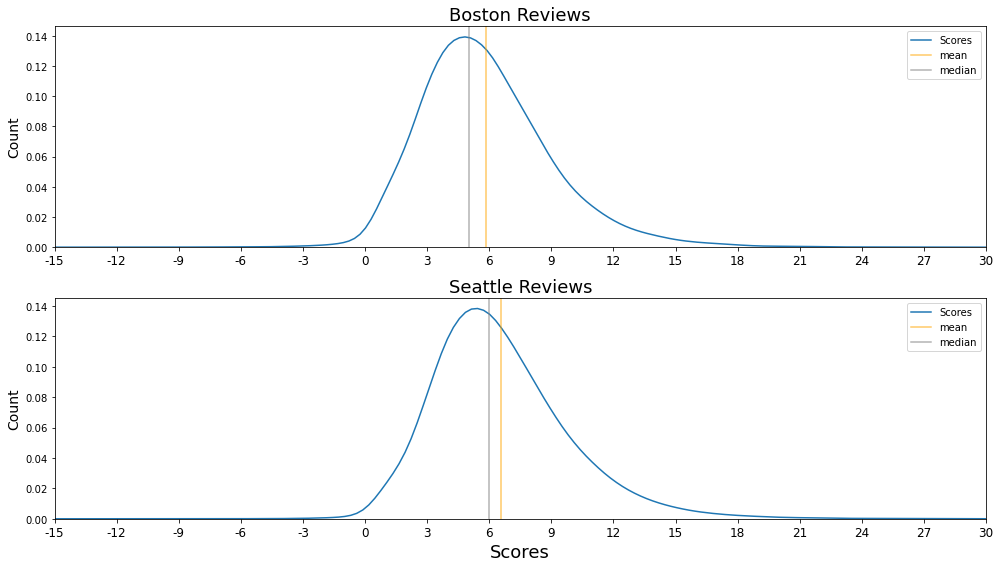

In [90]:
print_side_by_side(' Boston: ', '      Seattle: ', b = 0)
print_side_by_side(' Maximum score : ', b_rev_score.iloc[b_rev_score.score.idxmax()].score,
                   '      Maximum Score : ', s_rev_score.iloc[s_rev_score.score.idxmax()].score)
print_side_by_side(' Minimum Score : ', b_rev_score.iloc[b_rev_score.score.idxmin()].score,
                   '      Minimum Score : ', s_rev_score.iloc[s_rev_score.score.idxmin()].score)
print_side_by_side(' Most common score: ', b_rev_score['score'].mode().to_string(),
'      Most common score: ', s_rev_score['score'].mode().to_string())
print_side_by_side(' Mean score: ', round(b_rev_score['score'].mean(),2)
,'      Mean score: ', round(s_rev_score['score'].mean(),2))
print_side_by_side(' Median score: ',round( b_rev_score['score'].median(),2),
'      Median score: ', s_rev_score['score'].median())
print_side_by_side(' Standard deviation: ', round(b_rev_score['score'].std(),2)
,'      Standard deviation: ', round(s_rev_score['score'].std(),2))
# print_side_by_side(' Z score of -2: ', round(b_rev_score['score'].mean()-2*round(b_rev_score['score'].std(),2),1)
# ,'      Z score of -2: ', round(s_rev_score['score'].mean()-2*round(s_rev_score['score'].std(),2)),1)
# print('Score: ', b_rev_score.iloc[b_rev_score.score.idxmax()].score)
# b_rev_score.iloc[b_rev_score.score.idxmax()].comments


plt.figure(figsize = (14,8))
plt.subplot(2,1,1)
plt.title('Boston Reviews', fontsize = 18)
sns.kdeplot(b_rev_score.score, bw_adjust=2)
plt.axvline(x= b_rev_score['score'].mean(), color = 'orange', alpha = 0.6)
plt.axvline(x= b_rev_score['score'].median(), color = 'gray', alpha = 0.6)
plt.xlim(-15,30)
plt.xlabel('', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.legend(['Scores','mean', 'median'])
order = np.arange(-15,31,3)
plt.xticks(order,order, fontsize = 12)

plt.subplot(2,1,2)
plt.title('Seattle Reviews', fontsize = 18)
sns.kdeplot(s_rev_score.score, bw_adjust=2)
plt.axvline(x= s_rev_score['score'].mean(), color = 'orange', alpha = 0.6)
plt.axvline(x= s_rev_score['score'].median(), color = 'gray', alpha = 0.6)
plt.xlim(-15,30)
plt.xlabel('Scores', fontsize = 18)
plt.ylabel('Count', fontsize = 14)
plt.legend(['Scores','mean','median'])
plt.xticks(order,order, fontsize = 12)

plt.tight_layout();

>* <font size = '3'>**The scores clearly follow a normal distribution in both cities, with close standard deviations**</font>
>* <font size = '3'>**The mean score of Seattle (6.55) is a bit higher than Boston (5.84)**</font>
>* <font size = '3'>**The median score in both cities is a bit less than the mean which indicates a slight right skew**</font>

<font size = '3' >*Let'stake a look on the boxplots to have more robust insights*<font/>

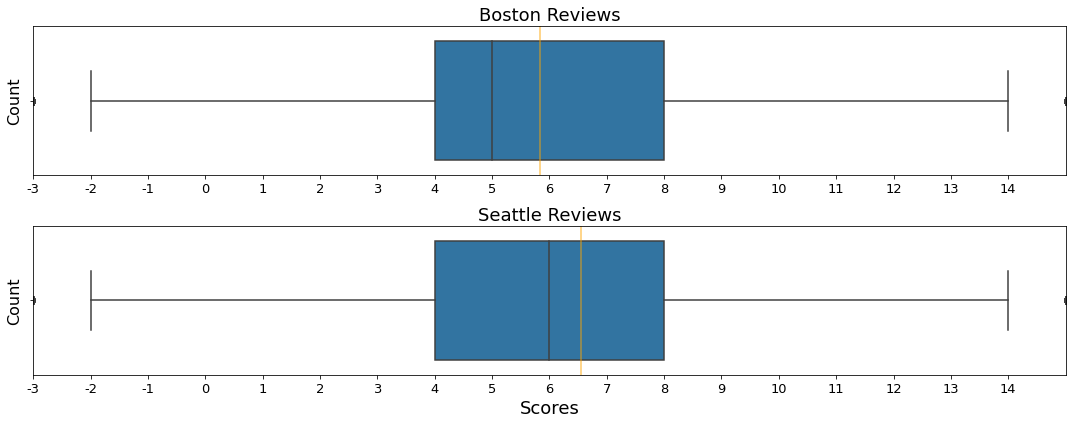

In [67]:
plt.figure(figsize = (15,6))
plt.subplot(2,1,1)
plt.title('Boston Reviews', fontsize = 18)
sns.boxplot(data = b_rev_score, x = b_rev_score.score)
plt.axvline(x= b_rev_score['score'].mean(), color = 'orange', alpha = 0.6)
# plt.axvline(x= b_rev_score['score'].mean()+2*round(b_rev_score['score'].std(),2), color = 'red', alpha = 0.6)
# plt.axvline(x= b_rev_score['score'].mean()-2*round(b_rev_score['score'].std(),2), color = 'red', alpha = 0.6)
plt.xlim(-3,15)
plt.ylabel('Count', fontsize = 16)
order = np.arange(-3,15,1)
plt.xticks(order,order, fontsize = 13)
plt.xlabel('')

plt.subplot(2,1,2)
plt.title('Seattle Reviews', fontsize = 18)
sns.boxplot(data = s_rev_score, x = s_rev_score.score)
plt.axvline(x= s_rev_score['score'].mean(), color = 'orange', alpha = 0.6)
# plt.axvline(x= s_rev_score['score'].mean()+2*round(s_rev_score['score'].std(),2), color = 'red', alpha = 0.6)
# plt.axvline(x= s_rev_score['score'].mean()-2*round(s_rev_score['score'].std(),2), color = 'red', alpha = 0.6)
plt.xlim(-3,15)
plt.xlabel('Scores', fontsize = 18)
plt.ylabel('Count', fontsize = 16)
plt.xticks(order,order, fontsize = 13)
plt.tight_layout();

>* <font size = '3'>**50% of The scores in both cities lies between 4 and 8**</font>
>* <font size = '3'>**The IQR of the scores in both cities lies between -2 to 14**</font>

<font size = '3' >*Finally, what's the proportion of negative scores in both cities*<font/>

In [27]:
b_rev_score['grade']= b_rev_score['score'].apply(lambda x: 1 if x >0 else 0)
s_rev_score['grade']= s_rev_score['score'].apply(lambda x: 1 if x >0 else 0)
print_side_by_side('Boston: ', 'Seattle: ', b=0)
print_side_by_side('Negative reviews proportion: ',
round(b_rev_score['grade'][b_rev_score.grade == 0].count()/b_rev_score.shape[0],3),
'Negative reviews proportion: ',
round(s_rev_score['grade'][s_rev_score.grade == 0].count()/s_rev_score.shape[0],3))

Boston:                                                  Seattle: 
Negative reviews proportion:   0.012                     Negative reviews proportion:   0.005


><font size = '3'>**Further exploration:**</font>
<br>
>* <font size = '3'>**Use an NLP model be used to better classify the sentiment in the reviews**</font>
>* <font size = '3'>**Explore how to predict reviews using aspects of a listing**</font>
>* <font size = '3'>**Explore the relatioship between average price per meter in each city's estates/ temperature trends  and reviews**</font>

_______________________________________________________________________________________________________________________